In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# IMPORT

In [60]:
df_ads = pd.read_csv('CTR Prediction - 2022 DIGIX Global AI Challenge/train/train_data_ads.csv')
df_feeds = pd.read_csv('CTR Prediction - 2022 DIGIX Global AI Challenge/train/train_data_feeds.csv')

In [61]:
df_ads.shape, df_feeds.shape

((7675517, 35), (3227732, 28))

In [62]:
# check for same columns

a = set(df_ads.columns)
b = set(df_feeds.columns)

a & b

# note that label and u_newsCatInterestsST are not same in the two datasets

{'label', 'u_feedLifeCycle', 'u_newsCatInterestsST', 'u_refreshTimes'}

In [63]:
df_ads.drop(columns='site_id', inplace=True)

In [56]:
# df_feeds.drop(columns=['u_feedLifeCycle', 'u_refreshTimes'], inplace=True)

In [64]:
# check for uniques

[f'{col}: {len(df_ads[col].unique())}' for col in df_ads.columns]

['log_id: 1176633',
 'label: 2',
 'user_id: 65297',
 'age: 8',
 'gender: 3',
 'residence: 35',
 'city: 341',
 'city_rank: 4',
 'series_dev: 27',
 'series_group: 7',
 'emui_dev: 27',
 'device_name: 256',
 'device_size: 1547',
 'net_type: 6',
 'task_id: 11209',
 'adv_id: 12615',
 'creat_type_cd: 9',
 'adv_prim_id: 545',
 'inter_type_cd: 4',
 'slot_id: 60',
 'spread_app_id: 116',
 'hispace_app_tags: 43',
 'app_second_class: 20',
 'app_score: 3',
 'ad_click_list_v001: 108720',
 'ad_click_list_v002: 95376',
 'ad_click_list_v003: 61102',
 'ad_close_list_v001: 3883',
 'ad_close_list_v002: 2701',
 'ad_close_list_v003: 1715',
 'pt_d: 5436',
 'u_newsCatInterestsST: 187576',
 'u_refreshTimes: 10',
 'u_feedLifeCycle: 8']

In [65]:
[f'{col}: {len(df_feeds[col].unique())}' for col in df_feeds.columns]

['u_userId: 180123',
 'u_phonePrice: 7',
 'u_browserLifeCycle: 8',
 'u_browserMode: 8',
 'u_feedLifeCycle: 8',
 'u_refreshTimes: 10',
 'u_newsCatInterests: 202636',
 'u_newsCatDislike: 810',
 'u_newsCatInterestsST: 625044',
 'u_click_ca2_news: 758921',
 'i_docId: 98600',
 'i_s_sourceId: 4040',
 'i_regionEntity: 378',
 'i_cat: 208',
 'i_entities: 92747',
 'i_dislikeTimes: 10',
 'i_upTimes: 10',
 'i_dtype: 5',
 'e_ch: 19',
 'e_m: 274',
 'e_po: 27',
 'e_pl: 3113',
 'e_rn: 99',
 'e_section: 2',
 'e_et: 3663',
 'label: 2',
 'cillabel: 2',
 'pro: 85']

# SUBSET

feeds dataset has more unique user id, if join on right(feeds), there will be a lot NAN. We needs to find a way to impute the nan.

but if join by ads, it will lose many information.

we could compare both results.

but let's do inner join, it won't have nan, it will be easier to work with for now.

### INNER JOIN

In [66]:
df_ads_sub = df_ads.sample(n=100000, random_state=2333)
df_ads_sub.label.value_counts(normalize=True)

# pick one subset
# that has most similar label value counts

0    0.98436
1    0.01564
Name: label, dtype: float64

In [67]:
df_feeds_sub = df_feeds.sample(n=100000, random_state=2333)

In [68]:
df_ads_sub.shape, df_feeds_sub.shape

((100000, 34), (100000, 28))

In [69]:
df = df_ads_sub.merge(df_feeds_sub, left_on='user_id', right_on='u_userId', how='inner')

In [70]:
df.shape

(294393, 62)

In [71]:
df.head(5)

,log_id,label_x,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST_x,u_refreshTimes_x,u_feedLifeCycle_x,u_userId,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle_y,u_refreshTimes_y,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST_y,u_click_ca2_news,i_docId,i_s_sourceId,i_regionEntity,i_cat,i_entities,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label_y,cillabel,pro
0,758591,0,152172,3,2,46,138,2,24,2,23,311,1134,6,35264,16799,8,1173,5,38,162,47,14,10.0,34099^13546^24949^21493^30157,1036^1482^1105^2066^1633,312^257^306^114^162,24107,1218,173,202206051153,78^98^98^86^98,6,17,152172,16,17,10,17,6,98^98^98^86^112,0,78^109^98^98^112,197^17^112^100^102,e624404378e9d97ef78b6eb6da811314a4ca3f5e,32821a20916400e7432f2284a15af0143e2c0150,0,50,NaN,9,9,11,19,1217,4,1116,2,0,202206052119,-1,-1,0
1,758591,0,152172,3,2,46,138,2,24,2,23,311,1134,6,35264,16799,8,1173,5,38,162,47,14,10.0,34099^13546^24949^21493^30157,1036^1482^1105^2066^1633,312^257^306^114^162,24107,1218,173,202206051153,78^98^98^86^98,6,17,152172,16,17,10,17,6,98^98^98^86^78,0,98^71^218^94^78,98^94^71^218^65,512546f35e013ed7c2af32c3902c11a1c0d4ec01,8bfd032b50b89d2eaa8c957052a757c6739d1438,0,98,a194a902ef5c00c1160c38c54a800ad0bd61601ad5ff5b...,0,0,11,19,1217,6,1431,1,1,202206071622,-1,-1,0
2,758562,0,152172,3,2,46,138,2,24,2,23,311,1134,7,12814,15050,10,1562,4,16,152,49,17,10.0,34099^13546^24949^21493^30157,1036^1482^1105^2066^1633,312^257^306^114^162,24107,1218,173,202206050707,78^98^98^86^98,6,17,152172,16,17,10,17,6,98^98^98^86^112,0,78^109^98^98^112,197^17^112^100^102,e624404378e9d97ef78b6eb6da811314a4ca3f5e,32821a20916400e7432f2284a15af0143e2c0150,0,50,NaN,9,9,11,19,1217,4,1116,2,0,202206052119,-1,-1,0
3,758562,0,152172,3,2,46,138,2,24,2,23,311,1134,7,12814,15050,10,1562,4,16,152,49,17,10.0,34099^13546^24949^21493^30157,1036^1482^1105^2066^1633,312^257^306^114^162,24107,1218,173,202206050707,78^98^98^86^98,6,17,152172,16,17,10,17,6,98^98^98^86^78,0,98^71^218^94^78,98^94^71^218^65,512546f35e013ed7c2af32c3902c11a1c0d4ec01,8bfd032b50b89d2eaa8c957052a757c6739d1438,0,98,a194a902ef5c00c1160c38c54a800ad0bd61601ad5ff5b...,0,0,11,19,1217,6,1431,1,1,202206071622,-1,-1,0
4,766198,0,152172,3,2,46,138,2,24,2,23,311,1667,6,35264,16799,8,1173,5,17,162,47,14,10.0,22697^34099^13546^24949^21493,1369^1036^1482^1105^2066,162^312^257^306^114,24107,1218,173,202206060231,78^86^98^98^197,6,17,152172,16,17,10,17,6,98^98^98^86^112,0,78^109^98^98^112,197^17^112^100^102,e624404378e9d97ef78b6eb6da811314a4ca3f5e,32821a20916400e7432f2284a15af0143e2c0150,0,50,NaN,9,9,11,19,1217,4,1116,2,0,202206052119,-1,-1,0


In [77]:
# check for nan

df.isna().any().any()

# i_entities has nan

True

In [73]:
# check for uniques

[f'{col}: {len(df[col].unique())}' for col in df.columns]

['log_id: 75888',
 'label_x: 2',
 'user_id: 21312',
 'age: 8',
 'gender: 3',
 'residence: 35',
 'city: 338',
 'city_rank: 4',
 'series_dev: 25',
 'series_group: 7',
 'emui_dev: 24',
 'device_name: 226',
 'device_size: 649',
 'net_type: 6',
 'task_id: 5327',
 'adv_id: 5879',
 'creat_type_cd: 9',
 'adv_prim_id: 503',
 'inter_type_cd: 4',
 'slot_id: 57',
 'spread_app_id: 107',
 'hispace_app_tags: 41',
 'app_second_class: 20',
 'app_score: 3',
 'ad_click_list_v001: 35296',
 'ad_click_list_v002: 33503',
 'ad_click_list_v003: 24627',
 'ad_close_list_v001: 1636',
 'ad_close_list_v002: 1169',
 'ad_close_list_v003: 726',
 'pt_d: 5060',
 'u_newsCatInterestsST_x: 48732',
 'u_refreshTimes_x: 10',
 'u_feedLifeCycle_x: 8',
 'u_userId: 21312',
 'u_phonePrice: 7',
 'u_browserLifeCycle: 8',
 'u_browserMode: 8',
 'u_feedLifeCycle_y: 8',
 'u_refreshTimes_y: 10',
 'u_newsCatInterests: 31790',
 'u_newsCatDislike: 368',
 'u_newsCatInterestsST_y: 53797',
 'u_click_ca2_news: 56024',
 'i_docId: 19920',
 'i_s_s

In [ ]:
# check for datatype

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294393 entries, 0 to 294392
Data columns (total 63 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   log_id                  294393 non-null  int64  
 1   label_x                 294393 non-null  int64  
 2   user_id                 294393 non-null  int64  
 3   age                     294393 non-null  int64  
 4   gender                  294393 non-null  int64  
 5   residence               294393 non-null  int64  
 6   city                    294393 non-null  int64  
 7   city_rank               294393 non-null  int64  
 8   series_dev              294393 non-null  int64  
 9   series_group            294393 non-null  int64  
 10  emui_dev                294393 non-null  int64  
 11  device_name             294393 non-null  int64  
 12  device_size             294393 non-null  int64  
 13  net_type                294393 non-null  int64  
 14  task_id             

In [74]:
df_num = df.select_dtypes(include=['int64','float64'])

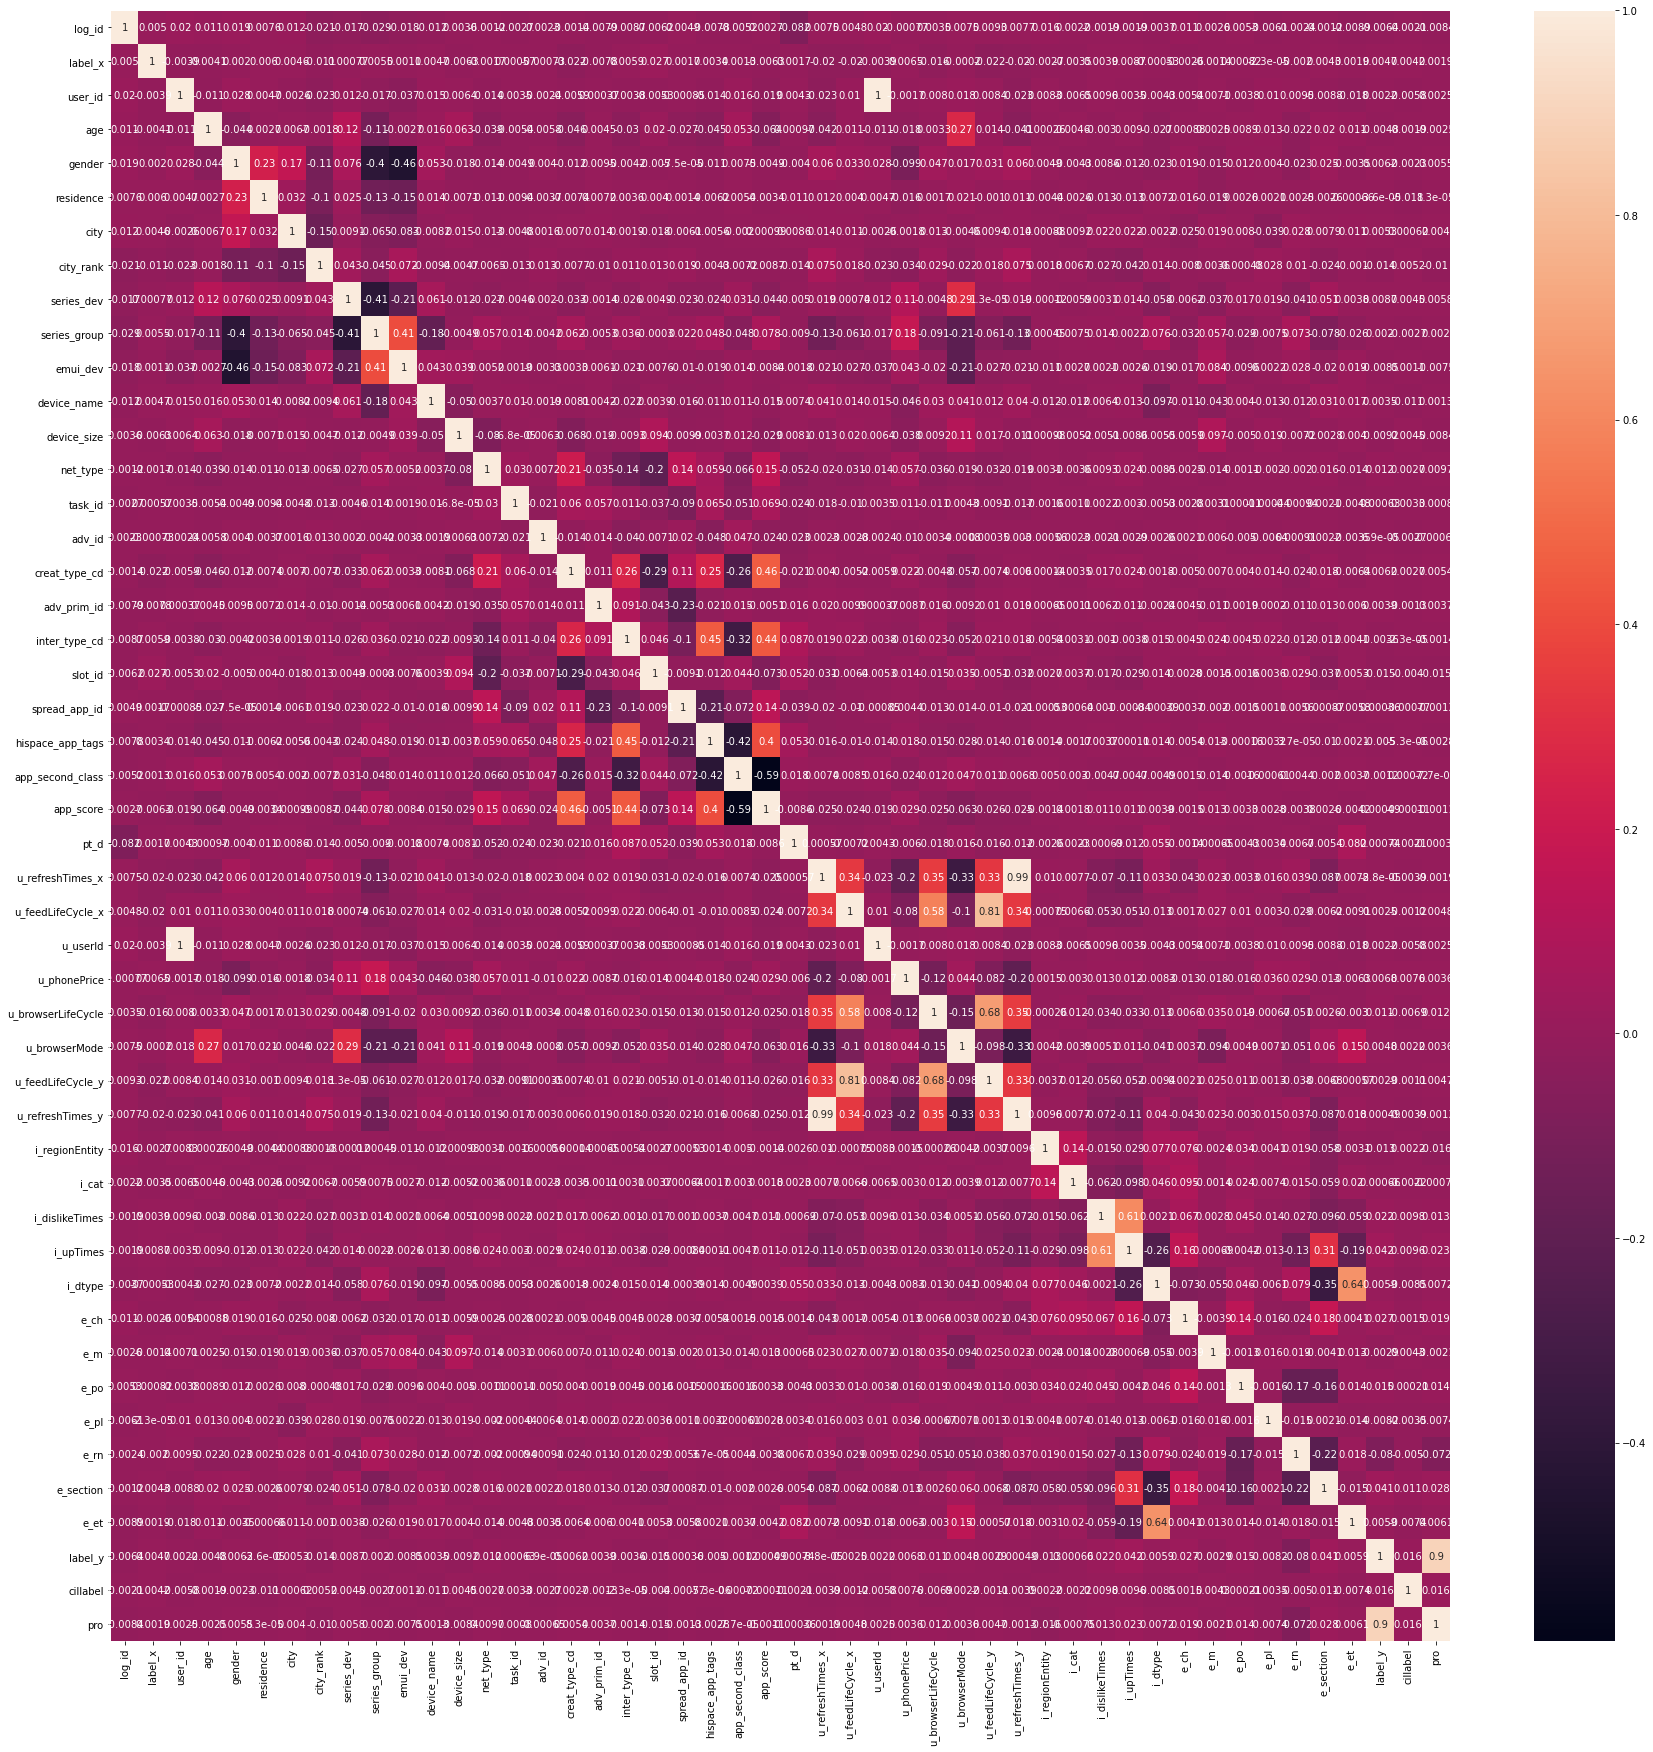

In [75]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_num.corr(),annot=True);

In [79]:
df_num.drop(columns=['pt_d','e_et','u_userId'], inplace=True)

c:\Users\qwswe\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [81]:
df_num.columns

Index(['log_id', 'label_x', 'user_id', 'age', 'gender', 'residence', 'city',
       'city_rank', 'series_dev', 'series_group', 'emui_dev', 'device_name',
       'device_size', 'net_type', 'task_id', 'adv_id', 'creat_type_cd',
       'adv_prim_id', 'inter_type_cd', 'slot_id', 'spread_app_id',
       'hispace_app_tags', 'app_second_class', 'app_score', 'u_refreshTimes_x',
       'u_feedLifeCycle_x', 'u_phonePrice', 'u_browserLifeCycle',
       'u_browserMode', 'u_feedLifeCycle_y', 'u_refreshTimes_y',
       'i_regionEntity', 'i_cat', 'i_dislikeTimes', 'i_upTimes', 'i_dtype',
       'e_ch', 'e_m', 'e_po', 'e_pl', 'e_rn', 'e_section', 'label_y',
       'cillabel', 'pro'],
      dtype='object')

In [82]:
df_num = df_num.rename(columns = {'label_x':'label'})

In [83]:
# export the simple subset for baseline
df_num.to_csv(r'C:\Users\qwswe\Documents\Flatiron\DS_P3\Output_Data\subset_300k_baseline.csv', index = False)

# log_id

In [ ]:
df['log_id'].value_counts()

# age

In [ ]:
df['age'].value_counts(normalize=True)

# seems like it's been divived into different groups

8    0.211386
7    0.201288
3    0.190323
2    0.123245
6    0.118895
5    0.114315
4    0.022630
9    0.017917
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Count'>

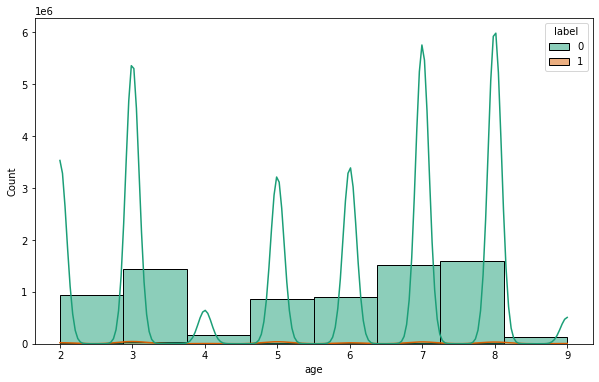

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))

sns.histplot(data = df, x = 'age', hue= 'label', bins=8, palette='Dark2', kde=True, ax = ax)


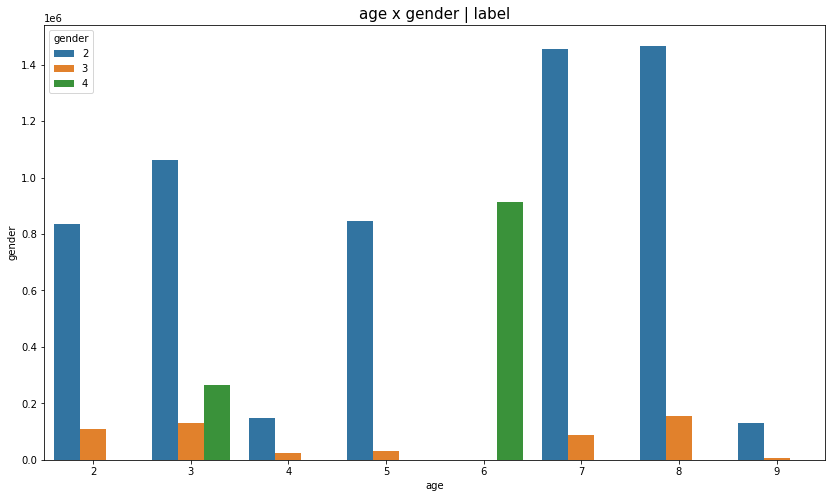

In [ ]:
fig,ax = plt.subplots(figsize=(14,8))

sns.countplot(data=df, x="age",hue='gender', ax=ax)

plt.title('age x gender | label',fontsize=15)
ax.set_xlabel('age')
ax.set_ylabel('gender');


# there are 3 gender
# may be female, male, unknown

In [ ]:
len(df.residence.unique())

35

<AxesSubplot:xlabel='residence', ylabel='Count'>

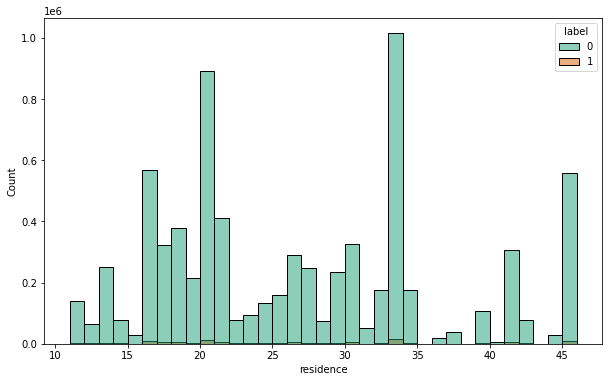

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))

sns.histplot(data = df, x = 'residence', hue= 'label', bins=35, palette='Dark2', ax = ax)

Text(0.5, 1.0, 'age x residence | label')

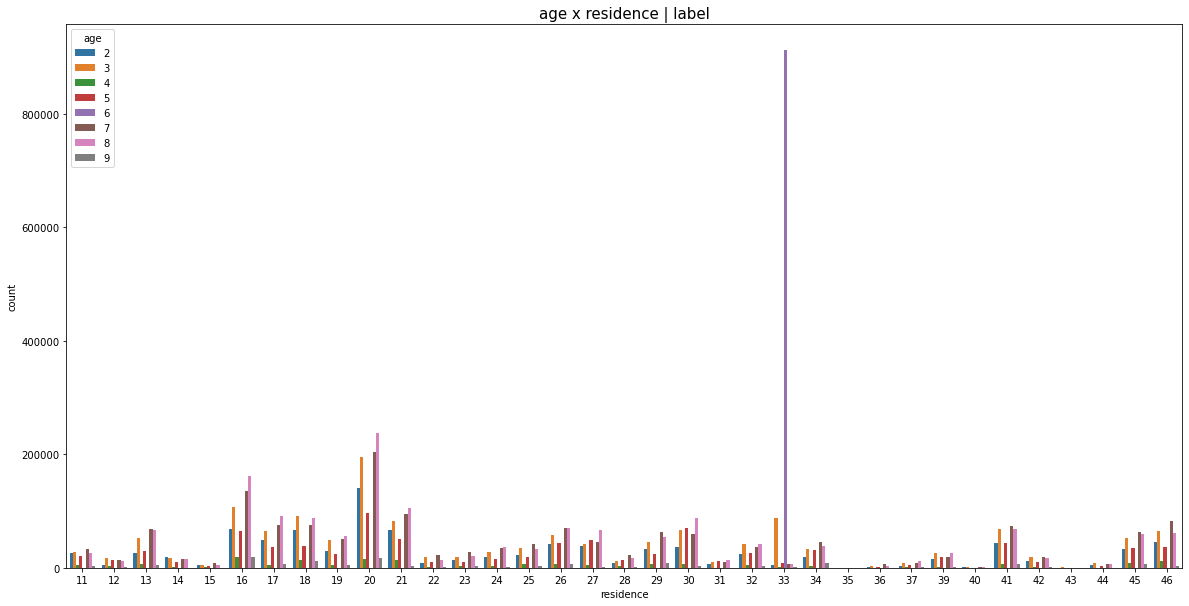

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))

sns.countplot(data=df, x="residence",hue='age', ax=ax)

plt.title('age x residence | label',fontsize=15)